# Pokeman Generator using Denosing Diffusion Probability Model (DDPM)
### https://arxiv.org/abs/2006.11239

In [1]:
import os 
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt 

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Get current working and input directories

In [2]:
current_path = os.getcwd()
print("current working directory: ", current_path)

# # kaggle path
# input_dir = '/kaggle/input/pokemon-image-dataset/images'

# windows path
input_dir = f'{current_path}\images'
print("input directory: ", input_dir)

current working directory:  C:\diffusion\pokemon
input directory:  C:\diffusion\pokemon\images


### Data Preprocessing

In [3]:
class PokemonDataset(Dataset):
    def __init__(self, dataframe, resize=(64, 64), grayscale=False, padding_color=(255, 255, 255)):
        super(PokemonDataset, self).__init__()
        
        self.df = dataframe
        self.resize = resize
        self.grayscale = grayscale
        self.padding_color = padding_color
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        item = self.df.iloc[index]
        image = Image.open(self.df.iloc[index]['filename'])
        
        image.thumbnail((self.resize), Image.LANCZOS) # resize the image with max width or height 
        w, h = image.size
        leftpad = self.resize[0] - w
        toppad = self.resize[1] - h
        
        padded_image = Image.new("RGB", self.resize, self.padding_color)
        padded_image.paste(image, (int(leftpad/2), int(toppad/2)))
        
        if self.grayscale: 
            return T.ToTensor()(padded_image.convert('L'))
        else:
            return T.ToTensor()(padded_image)
        

In [4]:
# Local Windows version
def get_data_path(image):
    fn, ext = os.path.splitext(os.path.basename(image))
    parts = image.rsplit('\\', 2)
    image_id = f'{parts[1]}_{fn}'
    image_name = parts[1]
    
    im = Image.open(image)
    width, height = im.size
    im.close()
    
    return image_id, image_name, image, width, height, width/height

# # Kaggle version
# def get_data_path(image):
#     fn, ext = os.path.splitext(os.path.basename(image))
#     # parts = image.rsplit('\\', 2)
#     parts = image.rsplit('/', 2)
#     image_id = f'{parts[1]}_{fn}'
#     image_name = parts[1]
    
#     im = Image.open(image)
#     width, height = im.size
#     im.close()
    
#     return image_id, image_name, image, width, height, width/height

### Import dataset

In [5]:
input_paths = glob(f'{input_dir}/*/*[0-9].*')
print(input_paths[0:10])

input_df = pd.DataFrame([get_data_path(image) for image in input_paths], columns=['id', 'name', 'filename', 'width', 'height', 'ratio'])
input_df

['C:\\diffusion\\pokemon\\images\\Abomasnow\\0.jpg', 'C:\\diffusion\\pokemon\\images\\Abomasnow\\1.jpg', 'C:\\diffusion\\pokemon\\images\\Abomasnow\\2.jpg', 'C:\\diffusion\\pokemon\\images\\Abomasnow\\3.jpg', 'C:\\diffusion\\pokemon\\images\\Abra\\0.jpg', 'C:\\diffusion\\pokemon\\images\\Abra\\1.jpg', 'C:\\diffusion\\pokemon\\images\\Abra\\2.jpg', 'C:\\diffusion\\pokemon\\images\\Abra\\3.jpg', 'C:\\diffusion\\pokemon\\images\\Absol\\0.jpg', 'C:\\diffusion\\pokemon\\images\\Absol\\1.jpg']


,id,name,filename,width,height,ratio
0,Abomasnow_0,Abomasnow,C:\diffusion\pokemon\images\Abomasnow\0.jpg,360,361,0.997230
1,Abomasnow_1,Abomasnow,C:\diffusion\pokemon\images\Abomasnow\1.jpg,360,321,1.121495
2,Abomasnow_2,Abomasnow,C:\diffusion\pokemon\images\Abomasnow\2.jpg,300,221,1.357466
3,Abomasnow_3,Abomasnow,C:\diffusion\pokemon\images\Abomasnow\3.jpg,300,270,1.111111
4,Abra_0,Abra,C:\diffusion\pokemon\images\Abra\0.jpg,360,253,1.422925
...,...,...,...,...,...,...
2498,Zygarde_1,Zygarde,C:\diffusion\pokemon\images\Zygarde\1.jpg,360,300,1.200000
2499,Zygarde_2,Zygarde,C:\diffusion\pokemon\images\Zygarde\2.jpg,360,313,1.150160
2500,Zygarde_3,Zygarde,C:\diffusion\pokemon\images\Zygarde\3.jpg,264,302,0.874172
2501,Zygarde_4,Zygarde,C:\diffusion\pokemon\images\Zygarde\4.jpg,302,302,1.000000


In [6]:
input_df['width'].max(), input_df['height'].max(), input_df[input_df['ratio'] < 1.0]

(360,
 400,
                id       name                                     filename  \
 0     Abomasnow_0  Abomasnow  C:\diffusion\pokemon\images\Abomasnow\0.jpg   
 6          Abra_2       Abra       C:\diffusion\pokemon\images\Abra\2.jpg   
 8         Absol_0      Absol      C:\diffusion\pokemon\images\Absol\0.jpg   
 9         Absol_1      Absol      C:\diffusion\pokemon\images\Absol\1.jpg   
 10        Absol_2      Absol      C:\diffusion\pokemon\images\Absol\2.jpg   
 ...           ...        ...                                          ...   
 2492      Zubat_1      Zubat      C:\diffusion\pokemon\images\Zubat\1.jpg   
 2493      Zubat_2      Zubat      C:\diffusion\pokemon\images\Zubat\2.jpg   
 2497    Zygarde_0    Zygarde    C:\diffusion\pokemon\images\Zygarde\0.jpg   
 2500    Zygarde_3    Zygarde    C:\diffusion\pokemon\images\Zygarde\3.jpg   
 2502    Zygarde_5    Zygarde    C:\diffusion\pokemon\images\Zygarde\5.jpg   
 
       width  height     ratio  
 0       360     

## Unet model and utility functions

### Utilities for diffusion

In [7]:
def cosine_f(t, noise_step, s):  # s=0.008
    
    return torch.pow(torch.cos(((t/noise_step +s)/(1+s)) * 0.5 * torch.pi), 2)
    

def get_noise_linear_schedules(beta_start, beta_end, noise_step):
    
    betas = torch.linspace(beta_start, beta_end, noise_step)
    
    return betas

def get_noise_cosine_schedules(beta_start, beta_end, noise_step, slowness_step, s=0.008):
    
    num_step = noise_step
    if slowness_step > noise_step:
        num_step = slowness_step
        
    t = torch.linspace(0, num_step, num_step+1)
    alphas_cumprod = cosine_f(t, num_step, s) / cosine_f(torch.tensor([0]), num_step, s)
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, 0.0001, 0.999)
    
    return betas[0:noise_step]

def generate_cumulative_alpha_linear(beta_start, beta_end, noise_step, s=0.008):
    
    betas = get_noise_linear_schedules(beta_start, beta_end, noise_step)
    alphas = 1.0 - betas
    
    return torch.cumprod(alphas, dim=0)
    
def generate_cumulative_alpha_cosine(beta_start, beta_end, noise_step, slowness_step, s=0.008):
    
    betas = get_noise_cosine_schedules(beta_start, beta_end, noise_step, slowness_step, s)
    alphas = 1.0 - betas
    
    return torch.cumprod(alphas, dim=0)

def generate_linear_beta(beta_start, beta_end, noise_step, s=0.008):
    betas = get_noise_linear_schedules(beta_start, beta_end, noise_step)
    
    return betas

def generate_cosine_beta(beta_start, beta_end, noise_step, slowness_step, s=0.008):
    betas = get_noise_cosine_schedules(beta_start, beta_end, noise_step, slowness_step, s)
    
    return betas

def generate_linear(beta_start, beta_end, noise_step):
    betas = get_noise_linear_schedules(beta_start, beta_end, noise_step)
    alphas = 1.0 - betas
    
    return betas, alphas, torch.cumprod(alphas, dim=0)

def generate_cosine(beta_start, beta_end, noise_step, slowness_step, s=0.008):
    betas = get_noise_cosine_schedules(beta_start, beta_end, noise_step, slowness_step, s)
    alphas = 1.0 - betas
    
    return betas, alphas, torch.cumprod(alphas, dim=0)

def generate_noisy_image(cumulative_alpha, image, t):
    # image (channel, rows, cols)
    sqrt_alpha = torch.sqrt(cumulative_alpha[t])
    sqrt_minus_alpha = torch.sqrt(1-cumulative_alpha[t])
    epsilon = torch.randn_like(image)
    
    noisy_image = sqrt_alpha * image + sqrt_minus_alpha * epsilon
    
    return noisy_image, epsilon

def get_image(cumulative_alpha, image, t):
    if t > 0 :
        return generate_noisy_image(cumulative_alpha, image, t-1)
    else:
        return image, None
    
#
# Return multiple images from more than one steps (ts)
#
def generate_noisy_images(cumulative_alpha, image, ts):
    # image (channel, rows, cols)
    sqrt_alpha = torch.sqrt(cumulative_alpha[ts])[:, None, None, None]
    sqrt_minus_alpha = torch.sqrt(1-cumulative_alpha[ts])[:, None, None, None]
    epsilon = torch.randn_like(image)
    
    noisy_image = sqrt_alpha * image + sqrt_minus_alpha * epsilon
    
    return noisy_image, epsilon

#
# Return multiple images
#
def get_images(cumulative_alpha, image, ts):  # ts only continas 1 or higher
    
    return generate_noisy_images(cumulative_alpha, image, ts-1)
    
def sample_steps(n=1, noise_step=1000):
    return torch.randint(1, noise_step, size=(n, ))

#
# Positional encoding
#

# e.g.,  dim = channels = 512
def positional_encoding(t, channels, device="cpu", n=10000):
    
    ts = t.unsqueeze(-1).type(torch.float)
    
    inv_freq = 1.0 / (n ** (torch.arange(0, channels, 2, device=device).float()/channels))
    
    pos_enc_a = torch.sin(ts.repeat(1, channels // 2) * inv_freq)
    pos_enc_b = torch.cos(ts.repeat(1, channels // 2) * inv_freq)
    
    d = 2
    n = pos_enc_a.shape[0] 
    m = pos_enc_a.shape[1] + pos_enc_b.shape[1]
    
    pos_enc = torch.stack((pos_enc_a, pos_enc_b), dim=d).view(n, m)
    
    return pos_enc

### Visualize positional encoding

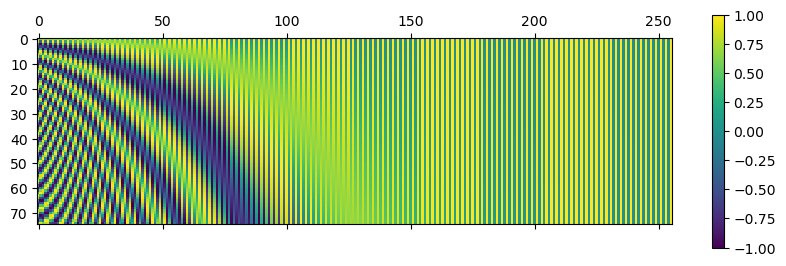

In [8]:
ts = torch.tensor([t+1 for t in range(75)])
epos = positional_encoding(ts, 256)

plt.rcParams["figure.figsize"] = (2,3)
cax = plt.matshow(epos)
plt.gcf().colorbar(cax)
plt.show()

### UNet model

In [9]:
class UnetDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.dconv = nn.Sequential(
            # double conv
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),  # better when the sample size is less than 8; used instead of BatchNorm
            nn.GELU(), # I want to try this instead of sigmoid or relu
            
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),  # better when the sample size is less than 8; used instead of BatchNorm     
        )
    
    def forward(self, input):
        
        return self.dconv(input)

    
class UnetDoubleDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.dconv = nn.Sequential(
            # double conv
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(1, in_channels),  # better when the sample size is less than 8; used instead of BatchNorm
            nn.GELU(), # I want to try this instead of sigmoid or relu
            
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(1, in_channels),  # better when the sample size is less than 8; used instead of BatchNorm
            nn.GELU(), # I want to try this instead of sigmoid or relu
            
            # double conv
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),  # better when the sample size is less than 8; used instead of BatchNorm
            nn.GELU(), # I want to try this instead of sigmoid or relu
            
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.GroupNorm(1, out_channels)  # better when the sample size is less than 8; used instead of BatchNorm
        )
    
    def forward(self, x):
        
        return self.dconv(x)

    
class UnetAttention(nn.Module):
    def __init__(self, channels, num_heads):
        super().__init__()
        
        self.channels = channels
        self.num_heads = num_heads
        
        self.mhatten = nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.lnorm = nn.LayerNorm([channels])
        self.feedforward = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(), # I want to try this instead of sigmoid or relu
            nn.Linear(channels, channels)
        )
    
    def forward(self, x):
        
        height = x.shape[-2]
        width = x.shape[-1]
        
        x1 = x.view(-1, self.channels, height*width).swapaxes(1, 2)
        x2 = self.lnorm(x1)
        atten_v1, _ = self.mhatten(x2, x2, x2)
        atten_v2 = atten_v1 + x1
        atten_v3 = self.feedforward(atten_v2) + atten_v2
        
        return atten_v3.swapaxes(2, 1).view(-1, self.channels, height, width)
          

class UnetDownSample(nn.Module):
    def __init__(self, in_channels, out_channels, seq_dim=256):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), # by default kernel_size == stride_size            
            # UnetDoubleConv(in_channels=in_channels, out_channels=out_channels)
            UnetDoubleDoubleConv(in_channels=in_channels, out_channels=out_channels)
        )

        self.silu = nn.SiLU() # used instead of sigmoid

        self.linear = nn.Linear(in_features=seq_dim, out_features=out_channels)

    def forward(self, x, posenc):

        down = self.silu(self.downsample(x))
        enc = self.linear(posenc)[:, :, None, None].repeat(1, 1, down.shape[-2], down.shape[-1])

        return down + enc


class UnetUpSample(nn.Module):
    def __init__(self, in_channels, out_channels, seq_dim=256):
        super().__init__()
        
        self.transpose = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
        # self.dconv = UnetDoubleConv(in_channels=in_channels, out_channels=out_channels)
        self.dconv = UnetDoubleDoubleConv(in_channels=in_channels, out_channels=out_channels)
        
        self.silu = nn.SiLU() # used instead of sigmoid
        
        self.linear = nn.Linear(in_features=seq_dim, out_features=out_channels)
        
    def forward(self, x, x_down, posenc):
        
        x_up = self.transpose(x)
        
        dh = x_down.shape[-2] - x_up.shape[-2]  # row
        dw = x_down.shape[-1] - x_up.shape[-1]  # col
        
        # apply ~equal number of padding on the left col, right col, top row and bottom row of the 2d tensor (e.g., image tensor) 
        x_up = F.pad(x_up, (dw//2, dw-(dw//2), dh//2, dh-(dh//2)))
        
        x_up_cat = torch.cat((x_up, x_down), dim=1)
        
        x_up_cat = self.silu(self.dconv(x_up_cat))
        
        enc = self.linear(posenc)[:, :, None, None].repeat(1, 1, x_up_cat.shape[-2], x_up_cat.shape[-1])
        
        return x_up_cat + enc
        
#
# Unet
#
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Unet construction
        
        # input (64x64 image) in_channels => 64
        self.inc = UnetDoubleConv(in_channels, 64)
        
        # Down
        #
        
        # 64 => 128
        self.down1 = UnetDownSample(64, 128)  
        
        # 128 channels, 32x32 image
        self.atten1 = UnetAttention(channels=128, num_heads=4)
        
        # 128 => 256
        self.down2 = UnetDownSample(128, 256)
        
        # 256 channels, 16x16 image
        self.atten2 = UnetAttention(channels=256, num_heads=4)
        
        # 256 => 256
        self.down3 = UnetDownSample(256, 256)
        
        # 256 channels, 8x8 image
        self.atten3 = UnetAttention(channels=256, num_heads=4)
        
        #
        # Bottom: instead of using maxpool and conv layer as specified in Unet paper, 
        # I have decided to use 3 double-convs. For 64x64, the image size becomes too small 4x4 with 1024 channels
        # 
        
        self.bottom1 = UnetDoubleConv(256, 512)
        self.bottom2 = UnetDoubleConv(512, 512)
        self.bottom3 = UnetDoubleConv(512, 512)
        
        # Up
        #
        
        # 512 => 256 8x8 => 16x16 images
        self.up3 = UnetUpSample(512, 256)
        
        # 256 channels, 16x16 image
        self.atten3_up = UnetAttention(channels=256, num_heads=4)
        
        # 256 => 128  16x16 => 32x32 images
        self.up2 = UnetUpSample(256, 128)
        
        # 128 channels, 32x32 image
        self.atten2_up = UnetAttention(channels=128, num_heads=4)
        
        # 128 => 64  32x32 => 64x64 images
        self.up1 = UnetUpSample(128, 64)
        
        # 64 channels, 64x64 image
        self.atten1_up = UnetAttention(channels=64, num_heads=4)
        
        # 64 => 3   64x64 image
        self.outc = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
        
        # self.silu2 = nn.SiLU();
            
    def forward(self, x, posenc):
        
        # input (64x64 image) in_channels => 64
        x1 = self.inc(x)
        
        # down
        
        # 64 => 128, 32x32 image
        x2 = self.down1(x1, posenc)
        x3 = self.atten1(x2)
        
        # 128 => 256, 16x16 image
        x4 = self.down2(x3, posenc)
        x5 = self.atten2(x4)
        
        # 256 => 512, 8x8 image
        x6 = self.down3(x5, posenc)
        x7 = self.atten3(x6)
        
        # bottom
        x8 = self.bottom1(x7)
        x9 = self.bottom2(x8)
        x10 = self.bottom3(x9)
        
        # up
    
        # 512 (256 + 256) => 256  16x16 image
        x11 = self.up3(x10, x5, posenc)        
        x12 = self.atten3_up(x11)
        
        # 256 (128 + 128) => 128  32x32 image
        x13 = self.up2(x12, x3, posenc)       
        x14 = self.atten2_up(x13)
        
        # 128 (64 + 64) => 64  64x64 image
        x15 = self.up1(x14, x1, posenc)       
        x16 = self.atten1_up(x15)
        
        return self.outc(x16)
         

### Image Sampling

In [10]:
def sample_image(model, beta, alpha, cumulative_alpha, step, n, height, width, channels = 256, device= "cpu"):
    print(f"{n} new images")
    
    beta = beta.to(device)
    alpha = alpha.to(device)
    cumulative_alpha = cumulative_alpha.to(device)
    
    model.eval()
    with torch.no_grad():
        # sample from norm distribution
        x = torch.randn((n, 3, height, width)).to(device)
        
        for i in tqdm(reversed(range(1, step)), total=step-1, position=0):
            
            ts= torch.tensor([i]).repeat(n).to(device)
            posenc = positional_encoding(ts, channels, device=device)
            
            pred_epsilon = model(x, posenc)
            
            s_alpha = alpha[ts][:, None, None, None] # alpha = 1. - beta
            s_alpha_hat = cumulative_alpha[ts][:, None, None, None]
            s_beta = beta[ts][:, None, None, None]
            
            if i > 1:
                epsilon = torch.randn_like(x)
            else:
                epsilon = torch.zeros_like(x)
            
            x = (1 / torch.sqrt(s_alpha)) * ( x - ((1 - s_alpha) / (torch.sqrt(1 - s_alpha_hat))) * pred_epsilon) + torch.sqrt(s_beta) * epsilon
    
    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x*255).type(torch.uint8)
    
    return x


### Normalize image dataset

In [11]:
def get_mean_std(loader):
    num_pixels = 0
    mean = 0.0
    std = 0.0
    for images in loader:
        batch, channels, height, width = images.shape
        # print(batch, channels, height, width)
        num_pixels += batch * height * width
        mean += images.mean(axis=(0, 2, 3)).sum()
        std += images.std(axis=(0, 2, 3)).sum()
    
    mean /= num_pixels
    std /= num_pixels
    
    return mean, std

# Normalization per channel
def get_means_stds(loader):
    batches = 0
    means = 0.0
    stds = 0.0
    
    for images in loader:
        batch, channels, height, width = images.shape
        
        means += images.mean([2, 3]).sum(axis=0)
        stds += images.std([2, 3]).sum(axis=0)
        batches += batch
    
    means /= batches
    stds /= batches
    
    return means, stds

## Model training

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16 #32 #12
TARGET_HEIGHT = 32 # 64
TARGET_WIDTH = 32 # 64

LEARNING_RATE = 0.0003 #0.0001
EPOCHS = 1000 #50

# used for positional encoding
CHANNELS = 256

# used for noising process
NOISE_STEP = 1000

#
# Load dataset
#

dataset = PokemonDataset(dataframe=input_df, 
                         resize=(TARGET_HEIGHT, TARGET_WIDTH), 
                         grayscale=False, 
                         padding_color=(255, 255, 255))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#
# Normalize images
#

# get per-channel mean and std of the image dataset
MEAN, STD = get_means_stds(dataloader)

# normalize
transform_norm = T.Compose([
    T.Normalize(MEAN, STD)
])

# un-normalize
MEAN_A = torch.tensor([0., 0., 0.])
STD_B = torch.tensor([1., 1., 1.])
STD_A = STD_B / STD
MEAN_B = (-1) * MEAN

transform_unnorm = T.Compose([
    T.Normalize(MEAN_A, STD_A),
    T.Normalize(MEAN_B, STD_B)
])


#
# Initiate model and start training
#

SHOW_SAMPLE = False

model = Unet(3, 3)
model.to(DEVICE)

# Optimizer
# 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
#
loss_fn = nn.MSELoss()

# For evaluation
#
losses = []
x_axis = []
y_axis = []

# cosine-based cumulative alphas
betas, alphas, cumulative_alphas = generate_cosine(beta_start=0.0001, 
                                                   beta_end=0.02, 
                                                   noise_step=NOISE_STEP, 
                                                   slowness_step=int(NOISE_STEP*1.25),
                                                   s=0.008)

# betas, alphas, cumulative_alphas = generate_linear(beta_start=0.0002, 
#                                    beta_end=0.02, 
#                                    noise_step=noise_step)

for epoch in range(1, EPOCHS+1):
    
    # train
    model.train(True)
    
    for index, images in enumerate(tqdm(dataloader)):
        
        images = transform_norm(images.to(DEVICE))
        
        ts = sample_steps(n=images.shape[0], noise_step=NOISE_STEP).to(DEVICE)
        posenc = positional_encoding(t=ts, channels=CHANNELS, device=DEVICE)
        
        xs, epsilons = get_images(cumulative_alphas.to(DEVICE), images, ts)
        pred_epsilons = model(xs, posenc)
        
        loss = loss_fn(epsilons, pred_epsilons)
        
        optimizer.zero_grad(True)
        loss.backward()
        
        losses.append(loss.item())
        
        optimizer.step()
        
    x_axis.append(epoch)
    y_axis.append(np.array(losses).mean())
    
    print(f"epoch: {epoch}, loss: {np.array(losses).mean()}")
    
    if epoch%50 == 0:
        PATH = f"pokeman_generator_ddpm_{epoch}.pt"
        LOSS = np.array(losses).mean()

        torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS
        }, PATH)
    
    if SHOW_SAMPLE:
        # 
        # Show sampled images
        #
        imgs = sample_image(model=model, 
                            beta=betas, 
                            alpha=alphas, 
                            cumulative_alpha=cumulative_alphas, 
                            step=NOISE_STEP, 
                            n=1, 
                            height=TARGET_HEIGHT, 
                            width=TARGET_WIDTH,
                            device=DEVICE)

        plt.rcParams["figure.figsize"] = (1,1)
        img = imgs.view((3, TARGET_HEIGHT, TARGET_WIDTH)).permute(1, 2, 0).cpu().numpy()
        plt.imshow(img)
        plt.show()


### Save checkpoint

In [ ]:
PATH = "pokeman_generator_ddpm_final.pt"
LOSS = np.array(losses).mean()

torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': LOSS
}, PATH)

## Load trained weights

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 16
TARGET_HEIGHT = 32
TARGET_WIDTH = 32

LEARNING_RATE = 0.0003
EPOCHS = 1000

CHANNELS = 256
NOISE_STEP = 1000

dataset = PokemonDataset(dataframe=input_df, resize=(TARGET_HEIGHT, TARGET_WIDTH), grayscale=False, padding_color=(255, 255, 255))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#
# Normalize images
#

# get per-channel mean and std of the image dataset
MEAN, STD = get_means_stds(dataloader)

# normalize
transform_norm = T.Compose([
    T.Normalize(MEAN, STD)
])

# un-normalize
MEAN_A = torch.tensor([0., 0., 0.])
STD_B = torch.tensor([1., 1., 1.])
STD_A = STD_B / STD
MEAN_B = (-1) * MEAN

transform_unnorm = T.Compose([
    T.Normalize(MEAN_A, STD_A),
    T.Normalize(MEAN_B, STD_B)
])

#
# Initialize model
#

model = Unet(3, 3)
model.to(DEVICE)

# Optimizer
# 
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
#
loss_fn = nn.MSELoss()


# Load model from file
#
checkpoint = torch.load('pokeman_generator_ddpm_final.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# cosine 
betas, alphas, cumulative_alphas = generate_cosine(beta_start=0.0001, 
                                                   beta_end=0.02, 
                                                   noise_step=NOISE_STEP, 
                                                   slowness_step=int(NOISE_STEP*1.25),
                                                   s=0.008)

## Show generated sample

10 new images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:25<00:00, 39.61it/s]


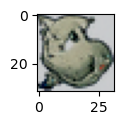

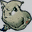

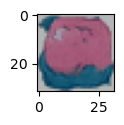

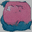

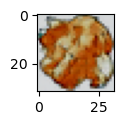

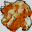

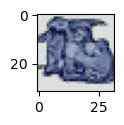

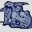

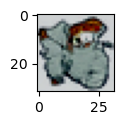

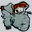

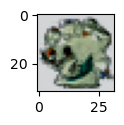

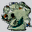

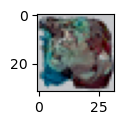

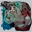

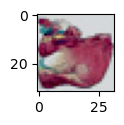

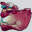

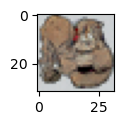

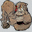

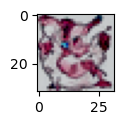

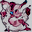

In [17]:
test_imgs = sample_image(model=model, 
                        beta=betas, 
                        alpha=alphas, 
                        cumulative_alpha=cumulative_alphas, 
                        step=NOISE_STEP, 
                        n=10, 
                        height=TARGET_HEIGHT, 
                        width=TARGET_WIDTH,
                        channels = CHANNELS,
                        device=DEVICE)

for test_img in test_imgs:
    # print(test_img.shape)
    plt.rcParams["figure.figsize"] = (1,1)
    ctest_img = test_img.view((3, TARGET_HEIGHT, TARGET_WIDTH)).permute(1, 2, 0).cpu().numpy()
    plt.imshow(ctest_img)
    plt.show()
    display(T.ToPILImage()(test_img.view((3, TARGET_HEIGHT, TARGET_WIDTH))))